<a href="https://colab.research.google.com/github/yash-kumar-yks/first-contributions/blob/master/image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

In [2]:
def rgb_gray(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray_img

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [4]:
print(x_train.shape)
print(x_test.shape)
img_dim = x_train.shape[1]
channels = 3

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
x_train_Gray = []
x_test_Gray = []


for i in range(x_train.shape[0]):
  img = x_train[i]
  x_train_Gray.append(rgb_gray(img))

for i in range(x_test.shape[0]):
  img = x_test[i]
  x_test_Gray.append(rgb_gray(img))

In [6]:
print(len(x_train_Gray))
print(len(x_test_Gray))

50000
10000


In [7]:
x_train_Gray = np.asarray(x_train_Gray)
x_test_Gray = np.asarray(x_test_Gray)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_Gray = x_train_Gray.astype('float32')/255
x_test_Gray = x_test_Gray.astype('float32')/255

In [8]:
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels)
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim, img_dim, 1)
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim, img_dim, 1)

In [9]:
input_shape = (img_dim, img_dim, 1)
lat_dim = 256

In [10]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)

In [11]:
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(lat_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder_model')
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
___________________________________________

In [12]:
latent_inputs = Input(shape = (lat_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [13]:
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

In [14]:
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)

In [15]:
decoder = Model(latent_inputs, outputs, name = 'decoder_model')

In [16]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')

In [17]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 256)               1418496   
_________________________________________________________________
decoder_model (Functional)   (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [18]:
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6)

In [19]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [20]:
print(filepath)

/content/saved_models/colorized_ae_model.h5


In [21]:
checkpoints = ModelCheckpoint(filepath = filepath, 
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True)

In [22]:

callbacks = [lr_reducer, checkpoints]

In [23]:
autoencoder.compile(loss = 'mse', optimizer = 'Adam', metrics = ['accuracy'])

In [24]:
autoencoder.compile(loss = 'mse', optimizer = 'Adam', metrics = ['accuracy'])


In [25]:
autoencoder.fit(x_train_Gray, x_train, validation_data = (x_test_Gray, x_test),epochs = 30, batch_size = 32, callbacks = callbacks)


Epoch 1/30
1563/1563 [==============================] - 47s 10ms/step - loss: 0.0220 - accuracy: 0.4660 - val_loss: 0.0106 - val_accuracy: 0.4695

Epoch 00001: val_loss improved from inf to 0.01056, saving model to /content/saved_models/colorized_ae_model.h5
Epoch 2/30
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0103 - accuracy: 0.5055 - val_loss: 0.0096 - val_accuracy: 0.4879

Epoch 00002: val_loss improved from 0.01056 to 0.00957, saving model to /content/saved_models/colorized_ae_model.h5
Epoch 3/30
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0091 - accuracy: 0.5138 - val_loss: 0.0088 - val_accuracy: 0.5052

Epoch 00003: val_loss improved from 0.00957 to 0.00884, saving model to /content/saved_models/colorized_ae_model.h5
Epoch 4/30
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0085 - accuracy: 0.5181 - val_loss: 0.0083 - val_accuracy: 0.5124

Epoch 00004: val_loss improved from 0.00884 to 0.00833, saving model

In [26]:
x_decoded = autoencoder.predict(x_test_Gray)

In [27]:
autoencoder.save('colourization_model.h5')

In [28]:
from google.colab import files
files.download('colourization_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

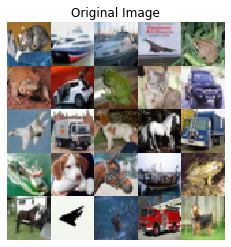

In [29]:
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Original Image')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

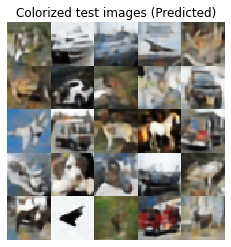

In [30]:
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()